In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle



    Only loading the 'en' tokenizer.



## Language modeling

### Data

The [large movie view dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

However, before we try to classify *sentiment*, we will simply try to create a *language model*; that is, a model that can predict the next word in a sentence. Why? Because our model first needs to understand the structure of English, before we can expect it to recognize positive vs negative sentiment.

So our plan of attack is the same as we used for Dogs v Cats: pretrain a model to do one thing (predict the next word), and fine tune it to do something else (classify sentiment).

Unfortunately, there are no good pretrained language models available to download, so we need to create our own. To follow along with this notebook, we suggest downloading the dataset from [this location](http://files.fast.ai/data/aclImdb.tgz) on files.fast.ai.

In [2]:
PATH='data/aclImdb/'

TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

imdbEr.txt  imdb.vocab  models/  README  test/  tmp/  train/


Let's look inside the training folder...

In [3]:
val_files = !ls {VAL}
val_files[:10]

['0_10.txt',
 '0_2.txt',
 '10000_4.txt',
 '10000_7.txt',
 '10001_1.txt',
 '10001_9.txt',
 '10002_3.txt',
 '10002_8.txt',
 '10003_3.txt',
 '10003_8.txt']

...and at an example review.

In [4]:
review = !cat {VAL}{val_files[6]}
review[0]

"Not even the Beatles could write songs everyone liked, and although Walter Hill is no mop-top he's second to none when it comes to thought provoking action movies. The nineties came and social platforms were changing in music and film, the emergence of the Rapper turned movie star was in full swing, the acting took a back seat to each man's overpowering regional accent and transparent acting. This was one of the many ice-t movies i saw as a kid and loved, only to watch them later and cringe. Bill Paxton and William Sadler are firemen with basic lives until a burning building tenant about to go up in flames hands over a map with gold implications. I hand it to Walter for quickly and neatly setting up the main characters and location. But i fault everyone involved for turning out Lame-o performances. Ice-t and cube must have been red hot at this time, and while I've enjoyed both their careers as rappers, in my opinion they fell flat in this movie. It's about ninety minutes of one guy ri

In [5]:
val_files[6]

'10002_3.txt'

Sounds like I'd really enjoy *Zombiegeddon*...

Now we'll check how many words are in the dataset.

In [6]:
!find {TRN} -name '*.txt' | xargs cat | wc -w

17486581


In [7]:
!find {VAL} -name '*.txt' | xargs cat | wc -w

5686719


Before we can analyze text, we must first *tokenize* it. This refers to the process of splitting a sentence into an array of words (or more generally, into an array of *tokens*).

In [8]:
' '.join(spacy_tok(review[0]))

"Not even the Beatles could write songs everyone liked , and although Walter Hill is no mop - top he 's second to none when it comes to thought provoking action movies . The nineties came and social platforms were changing in music and film , the emergence of the Rapper turned movie star was in full swing , the acting took a back seat to each man 's overpowering regional accent and transparent acting . This was one of the many ice - t movies i saw as a kid and loved , only to watch them later and cringe . Bill Paxton and William Sadler are firemen with basic lives until a burning building tenant about to go up in flames hands over a map with gold implications . I hand it to Walter for quickly and neatly setting up the main characters and location . But i fault everyone involved for turning out Lame - o performances . Ice - t and cube must have been red hot at this time , and while I 've enjoyed both their careers as rappers , in my opinion they fell flat in this movie . It 's about nin

We use Pytorch's [torchtext](https://github.com/pytorch/text) library to preprocess our data, telling it to use the wonderful [spacy](https://spacy.io/) library to handle tokenization.

First, we create a torchtext *field*, which describes how to preprocess a piece of text - in this case, we tell torchtext to make everything lowercase, and tokenize it with spacy.

In [9]:
TEXT = data.Field(lower=True, tokenize=spacy_tok)

fastai works closely with torchtext. We create a ModelData object for language modeling by taking advantage of `LanguageModelData`, passing it our torchtext field object, and the paths to our training, test, and validation sets. In this case, we don't have a separate test set, so we'll just use `VAL_PATH` for that too.

As well as the usual `bs` (batch size) parameter, we also not have `bptt`; this define how many words are processing at a time in each row of the mini-batch. More importantly, it defines how many 'layers' we will backprop through. Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences.

In [10]:
bs=64; bptt=70

In [11]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)

In [12]:
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

After building our `ModelData` object, it automatically fills the `TEXT` object with a very important attribute: `TEXT.vocab`. This is a *vocabulary*, which stores which words (or *tokens*) have been seen in the text, and how each word will be mapped to a unique integer id. We'll need to use this information again later, so we save it.

*(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of this notebook we used the `dill` library instead and imported it as `pickle`)*.

In [13]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [14]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(4602, 34945, 1, 20621966)

This is the start of the mapping from integer IDs to unique tokens.

In [15]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'it', 'in']

In [16]:
# 'stoi': 'string to int'
TEXT.vocab.stoi['the']

2

Note that in a `LanguageModelData` object there is only one item in each dataset: all the words of the text joined together.

In [17]:
md.trn_ds[0].text[:12]

['picking',
 'up',
 'the',
 'jacket',
 'of',
 'this',
 'dvd',
 'in',
 'the',
 'video',
 'store',
 'i']

torchtext will handle turning this words into integer IDs for us automatically.

In [18]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
 3658
   67
    2
 5530
    7
   13
  293
   11
    2
  391
 1058
   12
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

Our `LanguageModelData` object will create batches with 64 columns (that's our batch size), and varying sequence lengths of around 80 tokens (that's our `bptt` parameter - *backprop through time*).

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

In [19]:
next(iter(md.trn_dl))

(Variable containing:
   3658      2   1251  ...     687   1310    312
     67   8480   4536  ...    2035    735    863
      2     11  21594  ...       5     74     36
         ...            ⋱           ...         
     13     24     26  ...       5      8    862
     25    668      4  ...       2     36     54
     16     33     18  ...     663     54     13
 [torch.cuda.LongTensor of size 70x64 (GPU 0)], Variable containing:
     67
   8480
   4536
   ⋮   
  21794
      2
     37
 [torch.cuda.LongTensor of size 4480 (GPU 0)])

### Train

We have a number of parameters to set - we'll learn more about these later, but you should find these values suitable for many problems.

In [20]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

Researchers have found that large amounts of *momentum* (which we'll learn about later) don't work well with these kinds of *RNN* models, so we create a version of the *Adam* optimizer with less momentum than it's default of `0.9`.

In [21]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

fastai uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet!) to find the best values of the dropout parameters below - you just have to experiment...

However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.

In [22]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

As you can see below, I gradually tuned the language model in a few stages. I possibly could have trained it further (it wasn't yet overfitting), but I didn't have time to experiment more. Maybe you can see if you can train it to a better accuracy! (I used `lr_find` to find a good learning rate, but didn't save the output in this notebook. Feel free to try running it yourself now.)

In [90]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 3556/4602 [17:15<05:04,  3.43it/s, loss=22]  

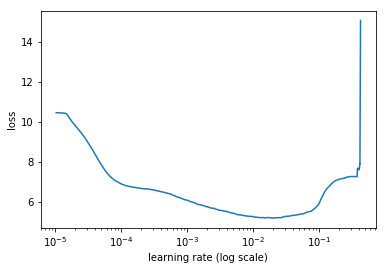

In [91]:
learner.sched.plot()

In [93]:
%time learner.fit(3e-3, 2, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  3%|▎         | 127/4602 [00:38<22:25,  3.33it/s, loss=8.41]


  5%|▌         | 253/4602 [01:15<21:32,  3.36it/s, loss=7.54]


  8%|▊         | 379/4602 [01:52<20:57,  3.36it/s, loss=6.46]


 11%|█         | 505/4602 [02:30<20:17,  3.36it/s, loss=5.93]


 14%|█▎        | 631/4602 [03:06<19:33,  3.38it/s, loss=5.68]


 16%|█▋        | 757/4602 [03:43<18:55,  3.39it/s, loss=5.56]


 19%|█▉        | 883/4602 [04:19<18:14,  3.40it/s, loss=5.45]


 22%|██▏       | 1009/4602 [04:56<17:37,  3.40it/s, loss=5.37]


 25%|██▍       | 1133/4602 [05:33<17:00,  3.40it/s, loss=5.31]


 27%|██▋       | 1257/4602 [06:08<16:21,  3.41it/s, loss=5.23]


 30%|███       | 1381/4602 [06:45<15:45,  3.41it/s, loss=5.17]


 33%|███▎      | 1505/4602 [07:21<15:08,  3.41it/s, loss=5.12]


 35%|███▌      | 1629/4602 [07:58<14:32,  3.41it/s, loss=5.11]


 38%|███▊      | 1753/4602 [08:34<13:56,  3.41it/s, loss=5.08]


 41%|████      | 1877/4602 [09:10<13:19,  3.41it/s, loss=5.05]


 43%|████▎     | 2001/4602 [09:47<12:43,  3.41it/s, loss=5.05]


 46%|████▌     | 2126/4602 [10:23<12:06,  3.41it/s, loss=4.98]


 49%|████▉     | 2250/4602 [11:00<11:30,  3.41it/s, loss=4.98]


 52%|█████▏    | 2374/4602 [11:36<10:53,  3.41it/s, loss=4.96]


 54%|█████▍    | 2498/4602 [12:13<10:18,  3.40it/s, loss=4.95]


 57%|█████▋    | 2622/4602 [12:49<09:41,  3.41it/s, loss=4.91]


 60%|█████▉    | 2746/4602 [13:26<09:04,  3.41it/s, loss=4.93]


 62%|██████▏   | 2870/4602 [14:02<08:28,  3.41it/s, loss=4.89]


 65%|██████▌   | 2994/4602 [14:38<07:51,  3.41it/s, loss=4.91]


 68%|██████▊   | 3118/4602 [15:14<07:15,  3.41it/s, loss=4.91]


 70%|███████   | 3242/4602 [15:51<06:39,  3.41it/s, loss=4.87]


 73%|███████▎  | 3366/4602 [16:27<06:02,  3.41it/s, loss=4.87]


 76%|███████▌  | 3490/4602 [17:03<05:26,  3.41it/s, loss=4.88]


 79%|███████▊  | 3614/4602 [17:40<04:49,  3.41it/s, loss=4.87]


 81%|████████  | 3738/4602 [18:17<04:13,  3.41it/s, loss=4.87]


 84%|████████▍ | 3862/4602 [18:53<03:37,  3.41it/s, loss=4.86]


 87%|████████▋ | 3986/4602 [19:30<03:00,  3.40it/s, loss=4.83]


 89%|████████▉ | 4110/4602 [20:07<02:24,  3.40it/s, loss=4.84]


 92%|█████████▏| 4234/4602 [20:43<01:48,  3.40it/s, loss=4.85]


 95%|█████████▍| 4358/4602 [21:20<01:11,  3.40it/s, loss=4.86]


 97%|█████████▋| 4482/4602 [21:57<00:35,  3.40it/s, loss=4.83]


100%|██████████| 4602/4602 [22:32<00:00,  3.40it/s, loss=4.84]
                                                              [ 0.       4.84384  4.7299 ]

  0%|          | 3/4602 [00:01<26:57,  2.84it/s, loss=4.84]


  3%|▎         | 131/4602 [00:38<21:40,  3.44it/s, loss=4.89]


  6%|▌         | 257/4602 [01:15<21:11,  3.42it/s, loss=4.92]


  8%|▊         | 383/4602 [01:52<20:38,  3.41it/s, loss=4.89]


 11%|█         | 509/4602 [02:29<20:01,  3.41it/s, loss=4.85]


 14%|█▍        | 635/4602 [03:06<19:23,  3.41it/s, loss=4.84]


 17%|█▋        | 761/4602 [03:42<18:44,  3.42it/s, loss=4.86]


 19%|█▉        | 887/4602 [04:19<18:08,  3.41it/s, loss=4.84]


 22%|██▏       | 1013/4602 [04:56<17:31,  3.41it/s, loss=4.82]


 25%|██▍       | 1137/4602 [05:33<16:54,  3.41it/s, loss=4.83]


 27%|██▋       | 1261/4602 [06:09<16:20,  3.41it/s, loss=4.79]


 30%|███       | 1386/4602 [06:46<15:43,  3.41it/s, loss=4.78]


 33%|███▎      | 1510/4602 [07:22<15:06,  3.41it/s, loss=4.75]


 36%|███▌      | 1634/4602 [07:59<14:30,  3.41it/s, loss=4.76]


 38%|███▊      | 1758/4602 [08:34<13:53,  3.41it/s, loss=4.76]


 41%|████      | 1882/4602 [09:11<13:16,  3.41it/s, loss=4.75]


 44%|████▎     | 2006/4602 [09:47<12:40,  3.41it/s, loss=4.77]


 46%|████▋     | 2130/4602 [10:24<12:04,  3.41it/s, loss=4.73]


 49%|████▉     | 2254/4602 [11:00<11:28,  3.41it/s, loss=4.72]


 52%|█████▏    | 2378/4602 [11:37<10:52,  3.41it/s, loss=4.72]


 54%|█████▍    | 2502/4602 [12:13<10:15,  3.41it/s, loss=4.73]


 57%|█████▋    | 2626/4602 [12:49<09:39,  3.41it/s, loss=4.7]


 60%|█████▉    | 2750/4602 [13:25<09:02,  3.41it/s, loss=4.72]


 62%|██████▏   | 2874/4602 [14:02<08:26,  3.41it/s, loss=4.69]


 65%|██████▌   | 2998/4602 [14:38<07:50,  3.41it/s, loss=4.7]


 68%|██████▊   | 3122/4602 [15:14<07:13,  3.41it/s, loss=4.71]


 71%|███████   | 3246/4602 [15:50<06:37,  3.41it/s, loss=4.68]


 73%|███████▎  | 3370/4602 [16:27<06:00,  3.41it/s, loss=4.67]


 76%|███████▌  | 3494/4602 [17:04<05:24,  3.41it/s, loss=4.69]


 79%|███████▊  | 3618/4602 [17:39<04:48,  3.41it/s, loss=4.69]


 81%|████████▏ | 3742/4602 [18:15<04:11,  3.41it/s, loss=4.69]


 84%|████████▍ | 3866/4602 [18:52<03:35,  3.41it/s, loss=4.66]


 87%|████████▋ | 3990/4602 [19:28<02:59,  3.41it/s, loss=4.64]


 89%|████████▉ | 4114/4602 [20:04<02:22,  3.41it/s, loss=4.65]


 92%|█████████▏| 4238/4602 [20:40<01:46,  3.42it/s, loss=4.66]


 95%|█████████▍| 4362/4602 [21:18<01:10,  3.41it/s, loss=4.65]


 97%|█████████▋| 4486/4602 [21:54<00:33,  3.41it/s, loss=4.62]


100%|██████████| 4602/4602 [22:28<00:00,  3.41it/s, loss=4.64]
                                                              [ 1.       4.63518  4.51357]

  0%|          | 7/4602 [00:02<25:36,  2.99it/s, loss=4.63]


  3%|▎         | 134/4602 [00:39<21:58,  3.39it/s, loss=4.62]


  6%|▌         | 260/4602 [01:16<21:25,  3.38it/s, loss=4.62]


  8%|▊         | 386/4602 [01:54<20:49,  3.37it/s, loss=4.61]


 11%|█         | 512/4602 [02:31<20:07,  3.39it/s, loss=4.58]


 14%|█▍        | 638/4602 [03:08<19:31,  3.38it/s, loss=4.59]


 17%|█▋        | 765/4602 [03:45<18:53,  3.39it/s, loss=4.6]


 19%|█▉        | 892/4602 [04:23<18:15,  3.39it/s, loss=4.59]


 22%|██▏       | 1017/4602 [05:00<17:38,  3.39it/s, loss=4.59]


 25%|██▍       | 1141/4602 [05:36<17:01,  3.39it/s, loss=4.59]


 27%|██▋       | 1265/4602 [06:12<16:23,  3.39it/s, loss=4.58]


 30%|███       | 1389/4602 [06:49<15:46,  3.39it/s, loss=4.57]


 33%|███▎      | 1513/4602 [07:25<15:09,  3.40it/s, loss=4.56]


 36%|███▌      | 1637/4602 [08:01<14:32,  3.40it/s, loss=4.55]


 38%|███▊      | 1761/4602 [08:37<13:55,  3.40it/s, loss=4.56]


 41%|████      | 1885/4602 [09:14<13:18,  3.40it/s, loss=4.57]


 44%|████▎     | 2009/4602 [09:50<12:42,  3.40it/s, loss=4.58]


 46%|████▋     | 2133/4602 [10:27<12:06,  3.40it/s, loss=4.54]


 49%|████▉     | 2257/4602 [11:03<11:29,  3.40it/s, loss=4.55]


 52%|█████▏    | 2381/4602 [11:40<10:53,  3.40it/s, loss=4.54]


 54%|█████▍    | 2505/4602 [12:17<10:16,  3.40it/s, loss=4.54]


 57%|█████▋    | 2629/4602 [12:53<09:40,  3.40it/s, loss=4.53]


 60%|█████▉    | 2753/4602 [13:30<09:04,  3.40it/s, loss=4.55]


 63%|██████▎   | 2877/4602 [14:06<08:27,  3.40it/s, loss=4.52]


 65%|██████▌   | 3001/4602 [14:42<07:51,  3.40it/s, loss=4.54]


 68%|██████▊   | 3125/4602 [15:19<07:14,  3.40it/s, loss=4.55]


 71%|███████   | 3249/4602 [15:56<06:38,  3.40it/s, loss=4.53]


 73%|███████▎  | 3373/4602 [16:32<06:01,  3.40it/s, loss=4.53]


 76%|███████▌  | 3497/4602 [17:09<05:25,  3.40it/s, loss=4.52]


 79%|███████▊  | 3621/4602 [17:45<04:48,  3.40it/s, loss=4.52]


 81%|████████▏ | 3745/4602 [18:21<04:12,  3.40it/s, loss=4.53]


 84%|████████▍ | 3869/4602 [18:57<03:35,  3.40it/s, loss=4.53]


 87%|████████▋ | 3993/4602 [19:33<02:58,  3.40it/s, loss=4.51]


 89%|████████▉ | 4117/4602 [20:09<02:22,  3.41it/s, loss=4.51]


 92%|█████████▏| 4241/4602 [20:45<01:46,  3.40it/s, loss=4.53]


 95%|█████████▍| 4365/4602 [21:21<01:09,  3.41it/s, loss=4.53]


 98%|█████████▊| 4489/4602 [21:57<00:33,  3.41it/s, loss=4.5]


100%|██████████| 4602/4602 [22:30<00:00,  3.41it/s, loss=4.52]
                                                              [ 2.       4.52078  4.42951]

CPU times: user 1h 1min 58s, sys: 14min 3s, total: 1h 16min 1s
Wall time: 1h 14min 53s


In [94]:
learner.save_encoder('adam1_enc')

In [95]:
%time learner.fit(3e-3, 2, wds=1e-6, cycle_len=1, cycle_save_name='adam3_10')

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))


  3%|▎         | 127/4602 [00:37<21:54,  3.40it/s, loss=4.51]


  5%|▌         | 253/4602 [01:14<21:17,  3.41it/s, loss=4.54]


  8%|▊         | 379/4602 [01:51<20:44,  3.39it/s, loss=4.58]


 11%|█         | 505/4602 [02:28<20:06,  3.40it/s, loss=4.58]


 14%|█▎        | 631/4602 [03:05<19:27,  3.40it/s, loss=4.58]


 16%|█▋        | 758/4602 [03:42<18:46,  3.41it/s, loss=4.62]


 19%|█▉        | 884/4602 [04:19<18:09,  3.41it/s, loss=4.62]


 22%|██▏       | 1010/4602 [04:56<17:34,  3.41it/s, loss=4.6]


 25%|██▍       | 1134/4602 [05:32<16:57,  3.41it/s, loss=4.61]


 27%|██▋       | 1258/4602 [06:09<16:22,  3.40it/s, loss=4.58]


 30%|███       | 1382/4602 [06:45<15:45,  3.41it/s, loss=4.59]


 33%|███▎      | 1506/4602 [07:22<15:08,  3.41it/s, loss=4.57]


 35%|███▌      | 1630/4602 [07:59<14:33,  3.40it/s, loss=4.58]


 38%|███▊      | 1754/4602 [08:35<13:57,  3.40it/s, loss=4.57]


 41%|████      | 1878/4602 [09:12<13:21,  3.40it/s, loss=4.58]


 44%|████▎     | 2002/4602 [09:48<12:44,  3.40it/s, loss=4.61]


 46%|████▌     | 2126/4602 [10:24<12:06,  3.41it/s, loss=4.55]


 49%|████▉     | 2250/4602 [10:59<11:29,  3.41it/s, loss=4.56]


 52%|█████▏    | 2374/4602 [11:36<10:53,  3.41it/s, loss=4.57]


 54%|█████▍    | 2498/4602 [12:13<10:17,  3.41it/s, loss=4.56]


 57%|█████▋    | 2622/4602 [12:50<09:41,  3.40it/s, loss=4.54]


 60%|█████▉    | 2746/4602 [13:27<09:05,  3.40it/s, loss=4.56]


 62%|██████▏   | 2870/4602 [14:04<08:29,  3.40it/s, loss=4.53]


 65%|██████▌   | 2994/4602 [14:41<07:53,  3.40it/s, loss=4.56]


 68%|██████▊   | 3118/4602 [15:17<07:16,  3.40it/s, loss=4.55]


 70%|███████   | 3242/4602 [15:53<06:40,  3.40it/s, loss=4.52]


 73%|███████▎  | 3366/4602 [16:29<06:03,  3.40it/s, loss=4.52]


 76%|███████▌  | 3490/4602 [17:06<05:27,  3.40it/s, loss=4.52]


 79%|███████▊  | 3614/4602 [17:42<04:50,  3.40it/s, loss=4.54]


 81%|████████  | 3738/4602 [18:18<04:13,  3.40it/s, loss=4.54]


 84%|████████▍ | 3862/4602 [18:54<03:37,  3.40it/s, loss=4.53]


 87%|████████▋ | 3986/4602 [19:30<03:00,  3.40it/s, loss=4.52]


 89%|████████▉ | 4110/4602 [20:07<02:24,  3.40it/s, loss=4.51]


 92%|█████████▏| 4234/4602 [20:44<01:48,  3.40it/s, loss=4.52]


 93%|█████████▎| 4297/4602 [21:02<01:29,  3.40it/s, loss=4.5]


 95%|█████████▍| 4359/4602 [21:20<01:11,  3.40it/s, loss=4.54]


 97%|█████████▋| 4484/4602 [21:57<00:34,  3.40it/s, loss=4.51]


100%|██████████| 4602/4602 [22:32<00:00,  3.40it/s, loss=4.53]
                                                              [ 0.       4.53179  4.39973]

  0%|          | 5/4602 [00:01<27:31,  2.78it/s, loss=4.53]


  3%|▎         | 132/4602 [00:39<22:08,  3.37it/s, loss=4.57]


  6%|▌         | 258/4602 [01:16<21:34,  3.36it/s, loss=4.58]


  8%|▊         | 384/4602 [01:53<20:42,  3.40it/s, loss=4.56]


 11%|█         | 510/4602 [02:30<20:05,  3.39it/s, loss=4.53]


 14%|█▍        | 636/4602 [03:08<19:34,  3.38it/s, loss=4.54]


 17%|█▋        | 762/4602 [03:45<18:55,  3.38it/s, loss=4.57]


 19%|█▉        | 888/4602 [04:23<18:20,  3.37it/s, loss=4.55]


 22%|██▏       | 1014/4602 [05:00<17:42,  3.38it/s, loss=4.56]


 25%|██▍       | 1138/4602 [05:36<17:05,  3.38it/s, loss=4.56]


 27%|██▋       | 1262/4602 [06:13<16:28,  3.38it/s, loss=4.55]


 30%|███       | 1386/4602 [06:49<15:51,  3.38it/s, loss=4.55]


 33%|███▎      | 1510/4602 [07:26<15:13,  3.38it/s, loss=4.54]


 36%|███▌      | 1634/4602 [08:02<14:36,  3.39it/s, loss=4.53]


 38%|███▊      | 1758/4602 [08:37<13:57,  3.40it/s, loss=4.54]


 41%|████      | 1882/4602 [09:14<13:20,  3.40it/s, loss=4.55]


 44%|████▎     | 2006/4602 [09:50<12:44,  3.40it/s, loss=4.55]


 46%|████▋     | 2130/4602 [10:27<12:08,  3.39it/s, loss=4.51]


 49%|████▉     | 2254/4602 [11:04<11:32,  3.39it/s, loss=4.53]


 52%|█████▏    | 2378/4602 [11:40<10:55,  3.39it/s, loss=4.52]


 54%|█████▍    | 2502/4602 [12:14<10:16,  3.40it/s, loss=4.52]


 57%|█████▋    | 2627/4602 [12:51<09:39,  3.41it/s, loss=4.49]


 60%|█████▉    | 2751/4602 [13:27<09:03,  3.41it/s, loss=4.52]


 62%|██████▏   | 2875/4602 [14:03<08:26,  3.41it/s, loss=4.49]


 65%|██████▌   | 2999/4602 [14:39<07:50,  3.41it/s, loss=4.52]


 68%|██████▊   | 3123/4602 [15:16<07:14,  3.41it/s, loss=4.52]


 71%|███████   | 3247/4602 [15:53<06:37,  3.40it/s, loss=4.49]


 73%|███████▎  | 3372/4602 [16:30<06:01,  3.40it/s, loss=4.49]


 76%|███████▌  | 3496/4602 [17:06<05:24,  3.41it/s, loss=4.51]


 79%|███████▊  | 3620/4602 [17:42<04:48,  3.41it/s, loss=4.51]


 81%|████████▏ | 3744/4602 [18:19<04:11,  3.41it/s, loss=4.51]


 83%|████████▎ | 3807/4602 [18:37<03:53,  3.41it/s, loss=4.52]


 85%|████████▌ | 3931/4602 [19:14<03:17,  3.41it/s, loss=4.5]


 88%|████████▊ | 4056/4602 [19:49<02:40,  3.41it/s, loss=4.49]


 91%|█████████ | 4180/4602 [20:26<02:03,  3.41it/s, loss=4.5]


 94%|█████████▎| 4304/4602 [21:03<01:27,  3.41it/s, loss=4.49]


 96%|█████████▌| 4428/4602 [21:39<00:51,  3.41it/s, loss=4.5]


 99%|█████████▉| 4552/4602 [22:15<00:14,  3.41it/s, loss=4.48]


100%|██████████| 4602/4602 [22:29<00:00,  3.41it/s, loss=4.49]
                                                              [ 1.       4.49097  4.37181]

CPU times: user 41min 19s, sys: 9min 24s, total: 50min 44s
Wall time: 49min 58s


In [96]:
learner.save_encoder('adam3_10_enc')

In [97]:
%time learner.fit(3e-3, 1, wds=1e-6, cycle_len=2, cycle_save_name='adam3_20')

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))


  3%|▎         | 127/4602 [00:37<21:54,  3.40it/s, loss=4.46]


  5%|▌         | 253/4602 [01:14<21:15,  3.41it/s, loss=4.47]


  8%|▊         | 379/4602 [01:50<20:29,  3.43it/s, loss=4.44]


 11%|█         | 505/4602 [02:27<19:56,  3.42it/s, loss=4.43]


 14%|█▎        | 631/4602 [03:04<19:23,  3.41it/s, loss=4.48]


 16%|█▋        | 757/4602 [03:41<18:47,  3.41it/s, loss=4.52]


 19%|█▉        | 883/4602 [04:19<18:11,  3.41it/s, loss=4.52]


 22%|██▏       | 1008/4602 [04:56<17:36,  3.40it/s, loss=4.52]


 25%|██▍       | 1132/4602 [05:32<16:58,  3.41it/s, loss=4.53]


 27%|██▋       | 1256/4602 [06:08<16:22,  3.41it/s, loss=4.52]


 30%|██▉       | 1380/4602 [06:45<15:47,  3.40it/s, loss=4.51]


 33%|███▎      | 1504/4602 [07:21<15:10,  3.40it/s, loss=4.5] 


 35%|███▌      | 1628/4602 [07:58<14:33,  3.41it/s, loss=4.53]


 38%|███▊      | 1752/4602 [08:34<13:56,  3.41it/s, loss=4.53]


 41%|████      | 1876/4602 [09:10<13:20,  3.41it/s, loss=4.52]


 43%|████▎     | 2000/4602 [09:46<12:43,  3.41it/s, loss=4.55]


 46%|████▌     | 2124/4602 [10:23<12:06,  3.41it/s, loss=4.52]


 49%|████▉     | 2248/4602 [10:59<11:30,  3.41it/s, loss=4.53]


 52%|█████▏    | 2372/4602 [11:35<10:53,  3.41it/s, loss=4.53]


 54%|█████▍    | 2496/4602 [12:12<10:17,  3.41it/s, loss=4.54]


 57%|█████▋    | 2620/4602 [12:48<09:41,  3.41it/s, loss=4.52]


 60%|█████▉    | 2744/4602 [13:24<09:04,  3.41it/s, loss=4.54]


 62%|██████▏   | 2868/4602 [14:01<08:28,  3.41it/s, loss=4.52]


 65%|██████▌   | 2992/4602 [14:37<07:52,  3.41it/s, loss=4.54]


 68%|██████▊   | 3116/4602 [15:13<07:15,  3.41it/s, loss=4.56]


 70%|███████   | 3240/4602 [15:50<06:39,  3.41it/s, loss=4.53]


 73%|███████▎  | 3364/4602 [16:27<06:03,  3.41it/s, loss=4.52]


 76%|███████▌  | 3488/4602 [17:04<05:27,  3.41it/s, loss=4.54]


 78%|███████▊  | 3612/4602 [17:40<04:50,  3.41it/s, loss=4.54]


 81%|████████  | 3736/4602 [18:17<04:14,  3.41it/s, loss=4.54]


 84%|████████▍ | 3860/4602 [18:53<03:37,  3.40it/s, loss=4.52]


 87%|████████▋ | 3984/4602 [19:30<03:01,  3.40it/s, loss=4.5]


 89%|████████▉ | 4108/4602 [20:06<02:25,  3.40it/s, loss=4.51]


 92%|█████████▏| 4232/4602 [20:43<01:48,  3.40it/s, loss=4.53]


 95%|█████████▍| 4356/4602 [21:20<01:12,  3.40it/s, loss=4.53]


 97%|█████████▋| 4480/4602 [21:56<00:35,  3.40it/s, loss=4.49]


100%|██████████| 4602/4602 [22:31<00:00,  3.40it/s, loss=4.51]
                                                              [ 0.       4.51235  4.3842 ]

  0%|          | 2/4602 [00:00<21:55,  3.50it/s, loss=4.51]


  3%|▎         | 129/4602 [00:38<22:00,  3.39it/s, loss=4.49]


  6%|▌         | 255/4602 [01:15<21:27,  3.38it/s, loss=4.5] 


  8%|▊         | 381/4602 [01:52<20:43,  3.39it/s, loss=4.47]


 11%|█         | 507/4602 [02:28<20:01,  3.41it/s, loss=4.44]


 14%|█▍        | 633/4602 [03:05<19:20,  3.42it/s, loss=4.43]


 16%|█▋        | 759/4602 [03:41<18:43,  3.42it/s, loss=4.45]


 19%|█▉        | 885/4602 [04:18<18:07,  3.42it/s, loss=4.46]


 22%|██▏       | 1011/4602 [04:55<17:30,  3.42it/s, loss=4.44]


 25%|██▍       | 1135/4602 [05:32<16:56,  3.41it/s, loss=4.45]


 27%|██▋       | 1259/4602 [06:09<16:19,  3.41it/s, loss=4.43]


 30%|███       | 1383/4602 [06:45<15:44,  3.41it/s, loss=4.43]


 33%|███▎      | 1507/4602 [07:22<15:08,  3.41it/s, loss=4.41]


 35%|███▌      | 1631/4602 [07:59<14:33,  3.40it/s, loss=4.43]


 38%|███▊      | 1755/4602 [08:36<13:57,  3.40it/s, loss=4.42]


 41%|████      | 1879/4602 [09:12<13:20,  3.40it/s, loss=4.43]


 44%|████▎     | 2003/4602 [09:49<12:44,  3.40it/s, loss=4.45]


 46%|████▌     | 2127/4602 [10:25<12:08,  3.40it/s, loss=4.41]


 49%|████▉     | 2251/4602 [11:02<11:31,  3.40it/s, loss=4.42]


 52%|█████▏    | 2375/4602 [11:38<10:54,  3.40it/s, loss=4.41]


 54%|█████▍    | 2499/4602 [12:14<10:18,  3.40it/s, loss=4.42]


 57%|█████▋    | 2624/4602 [12:50<09:40,  3.40it/s, loss=4.4]


 60%|█████▉    | 2748/4602 [13:26<09:04,  3.41it/s, loss=4.42]


 62%|██████▏   | 2872/4602 [14:03<08:28,  3.40it/s, loss=4.4]


 65%|██████▌   | 2996/4602 [14:40<07:52,  3.40it/s, loss=4.42]


 68%|██████▊   | 3120/4602 [15:17<07:15,  3.40it/s, loss=4.43]


 70%|███████   | 3244/4602 [15:53<06:39,  3.40it/s, loss=4.41]


 73%|███████▎  | 3368/4602 [16:29<06:02,  3.40it/s, loss=4.4]


 76%|███████▌  | 3492/4602 [17:06<05:26,  3.40it/s, loss=4.42]


 79%|███████▊  | 3617/4602 [17:41<04:49,  3.41it/s, loss=4.42]


 81%|████████▏ | 3741/4602 [18:18<04:12,  3.41it/s, loss=4.43]


 84%|████████▍ | 3865/4602 [18:54<03:36,  3.41it/s, loss=4.42]


 87%|████████▋ | 3989/4602 [19:31<03:00,  3.41it/s, loss=4.4]


 89%|████████▉ | 4113/4602 [20:08<02:23,  3.40it/s, loss=4.4]


 92%|█████████▏| 4238/4602 [20:45<01:46,  3.40it/s, loss=4.41]


 95%|█████████▍| 4362/4602 [21:21<01:10,  3.40it/s, loss=4.43]


 97%|█████████▋| 4486/4602 [21:58<00:34,  3.40it/s, loss=4.4]


100%|██████████| 4602/4602 [22:32<00:00,  3.40it/s, loss=4.41]
                                                              [ 1.       4.41016  4.32178]

CPU times: user 41min 17s, sys: 9min 24s, total: 50min 42s
Wall time: 49min 57s


In [23]:
learner.load_cycle('adam3_20', 0)

In the sentiment analysis section, we'll just need half of the language model - the *encoder*, so we save that part.

In [99]:
learner.save_encoder('adam3_20_enc')

In [24]:
learner.load_encoder('adam3_20_enc')

Language modeling accuracy is generally measured using the metric *perplexity*, which is simply `exp()` of the loss function we used.

In [25]:
math.exp(4.165)

64.3926824434624

### Test

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [67]:
m=learner.model
ss=""". So, it wasn't quite what I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

". So , it was n't quite what I was expecting , but I really liked it anyway ! The best"

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [68]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout - Set in evaluation mode
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [69]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['movie',
 'of',
 'performance',
 'thing',
 'scene',
 'film',
 'part',
 'actor',
 'acting',
 '.']

...and let's see if our model can generate a bit more text all by itself!

In [79]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. So, it wasn't quite what I was expecting, but I really liked it anyway! The best 

movie . <eos> i saw this movie on the big screen and i was very disappointed . i was very disappointed with the movie . i was very disappointed with the movie . i was very disappointed with the movie . i was very disappointed with the movie . i ...


### Sentiment

We'll need to the saved vocab from the language model, since we need to ensure the same words map to the same IDs.

In [80]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

`sequential=False` tells torchtext that a text field shouldn't be tokenized (in this case, we just want to store the 'positive' or 'negative' single label).

`splits` is a torchtext method that creates train, test, and validation sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets.

In [82]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

downloading aclImdb_v1.tar.gz


In [115]:
t = splits[0].examples[0]

In [116]:
t.label, ' '.join(t.text[:16])

('pos',
 'this modern film noir with its off beat humour and dizzying succession of plot twists delivers')

fastai can create a ModelData object directly from torchtext splits.

In [121]:
md2 = TextData.from_splits(PATH, splits, bs)

In [140]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_20_enc')

Because we're fine-tuning a pretrained model, we'll use differential learning rates, and also increase the max gradient for clipping, to allow the SGDR to work better.

In [141]:
m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

In [142]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.40859  0.27038  0.89363]                        



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.29592  0.20648  0.92011]                        



In [146]:
m3.fit(lrs, 2, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))




  0%|          | 0/390 [00:00<?, ?it/s]


  0%|          | 0/390 [00:00<?, ?it/s, loss=0.0413]


  0%|          | 1/390 [00:00<01:30,  4.30it/s, loss=0.0413]


  0%|          | 1/390 [00:00<02:16,  2.85it/s, loss=0.107] 


  1%|          | 2/390 [00:00<01:08,  5.68it/s, loss=0.107]


  1%|          | 2/390 [00:00<02:54,  2.22it/s, loss=0.115]


  1%|          | 3/390 [00:00<01:56,  3.32it/s, loss=0.115]


  1%|          | 3/390 [00:01<03:03,  2.11it/s, loss=0.121]


  1%|          | 4/390 [00:01<02:17,  2.81it/s, loss=0.121]



  1%|          | 4/390 [00:01<02:54,  2.21it/s, loss=0.158]


  1%|▏         | 5/390 [00:01<02:19,  2.76it/s, loss=0.158]

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration






  1%|▏         | 5/390 [00:02<03:19,  1.93it/s, loss=0.174]


  2%|▏         | 6/390 [00:02<02:46,  2.31it/s, loss=0.174]


  2%|▏         | 6/390 [00:02<03:01,  2.12it/s, loss=0.188]


  2%|▏         | 7/390 [00:02<02:35,  2.47it/s, loss=0.188]


  2%|▏         | 7/390 [00:03<02:44,  2.33it/s, loss=0.179]


  2%|▏         | 8/390 [00:03<02:23,  2.67it/s, loss=0.179]


  2%|▏         | 8/390 [00:03<03:02,  2.10it/s, loss=0.189]


  2%|▏         | 9/390 [00:03<02:41,  2.36it/s, loss=0.189]


  2%|▏         | 9/390 [00:04<03:13,  1.96it/s, loss=0.185]


  3%|▎         | 10/390 [00:04<02:54,  2.18it/s, loss=0.185]


  3%|▎         | 10/390 [00:05<03:16,  1.94it/s, loss=0.177]


  3%|▎         | 11/390 [00:05<02:57,  2.13it/s, loss=0.177]


  3%|▎         | 11/390 [00:06<03:34,  1.77it/s, loss=0.183]


  3%|▎         | 12/390 [00:06<03:16,  1.93it/s, loss=0.183]


  3%|▎         | 12/390 [00:06<03:21,  1.88it/s, loss=0.174]


  3%|▎         | 13/390 [00:06<03:05,  2.03it/s, loss=0.174]


 30%|███       | 118/390 [01:11<02:44,  1.66it/s, loss=0.198]


 31%|███       | 119/390 [01:11<02:42,  1.67it/s, loss=0.198]


 31%|███       | 119/390 [01:11<02:43,  1.65it/s, loss=0.198]


 31%|███       | 120/390 [01:11<02:41,  1.67it/s, loss=0.198]


 31%|███       | 120/390 [01:12<02:43,  1.65it/s, loss=0.196]


 31%|███       | 121/390 [01:12<02:41,  1.66it/s, loss=0.196]


 31%|███       | 121/390 [01:13<02:43,  1.65it/s, loss=0.195]


 31%|███▏      | 122/390 [01:13<02:41,  1.66it/s, loss=0.195]


 31%|███▏      | 122/390 [01:13<02:42,  1.65it/s, loss=0.195]


 32%|███▏      | 123/390 [01:13<02:40,  1.66it/s, loss=0.195]


 32%|███▏      | 123/390 [01:14<02:41,  1.65it/s, loss=0.194]


 32%|███▏      | 124/390 [01:14<02:39,  1.67it/s, loss=0.194]


 32%|███▏      | 124/390 [01:14<02:40,  1.66it/s, loss=0.195]


 32%|███▏      | 125/390 [01:14<02:38,  1.67it/s, loss=0.195]


 32%|███▏      | 125/390 [01:15<02:39,  1.67it/s, loss=0.199]


 32%|███▏      | 126/390 [01:15<02:37,  

 59%|█████▉    | 230/390 [02:22<01:38,  1.62it/s, loss=0.204]


 59%|█████▉    | 231/390 [02:22<01:37,  1.63it/s, loss=0.204]


 59%|█████▉    | 231/390 [02:22<01:38,  1.62it/s, loss=0.209]


 59%|█████▉    | 232/390 [02:22<01:37,  1.63it/s, loss=0.209]


 59%|█████▉    | 232/390 [02:23<01:37,  1.62it/s, loss=0.207]


 60%|█████▉    | 233/390 [02:23<01:36,  1.63it/s, loss=0.207]


 60%|█████▉    | 233/390 [02:23<01:36,  1.62it/s, loss=0.205]


 60%|██████    | 234/390 [02:23<01:35,  1.63it/s, loss=0.205]


 60%|██████    | 234/390 [02:23<01:35,  1.63it/s, loss=0.207]


 60%|██████    | 235/390 [02:23<01:34,  1.63it/s, loss=0.207]


 60%|██████    | 235/390 [02:24<01:35,  1.62it/s, loss=0.207]


 61%|██████    | 236/390 [02:24<01:34,  1.63it/s, loss=0.207]


 61%|██████    | 236/390 [02:24<01:34,  1.63it/s, loss=0.208]


 61%|██████    | 237/390 [02:24<01:33,  1.64it/s, loss=0.208]


 61%|██████    | 237/390 [02:25<01:33,  1.63it/s, loss=0.21] 


 61%|██████    | 238/390 [02:25<01:32,  

 88%|████████▊ | 342/390 [03:33<00:29,  1.60it/s, loss=0.205]


 88%|████████▊ | 343/390 [03:33<00:29,  1.60it/s, loss=0.205]


 88%|████████▊ | 343/390 [03:34<00:29,  1.60it/s, loss=0.204]


 88%|████████▊ | 344/390 [03:34<00:28,  1.60it/s, loss=0.204]


 88%|████████▊ | 344/390 [03:37<00:29,  1.58it/s, loss=0.202]


 88%|████████▊ | 345/390 [03:37<00:28,  1.59it/s, loss=0.202]


 88%|████████▊ | 345/390 [03:37<00:28,  1.58it/s, loss=0.2]  


 89%|████████▊ | 346/390 [03:37<00:27,  1.59it/s, loss=0.2]


 89%|████████▊ | 346/390 [03:38<00:27,  1.58it/s, loss=0.2]


 89%|████████▉ | 347/390 [03:38<00:27,  1.59it/s, loss=0.2]


 89%|████████▉ | 347/390 [03:38<00:27,  1.59it/s, loss=0.198]


 89%|████████▉ | 348/390 [03:38<00:26,  1.59it/s, loss=0.198]


 89%|████████▉ | 348/390 [03:38<00:26,  1.59it/s, loss=0.198]


 89%|████████▉ | 349/390 [03:38<00:25,  1.59it/s, loss=0.198]


 89%|████████▉ | 349/390 [03:40<00:25,  1.58it/s, loss=0.199]


 90%|████████▉ | 350/390 [03:40<00:25,  1.59it

 16%|█▋        | 64/390 [00:40<03:27,  1.57it/s, loss=0.198]


 16%|█▋        | 64/390 [00:41<03:33,  1.53it/s, loss=0.199]


 17%|█▋        | 65/390 [00:41<03:29,  1.55it/s, loss=0.199]


 17%|█▋        | 65/390 [00:42<03:30,  1.54it/s, loss=0.198]


 17%|█▋        | 66/390 [00:42<03:26,  1.57it/s, loss=0.198]


 17%|█▋        | 66/390 [00:42<03:27,  1.56it/s, loss=0.199]


 17%|█▋        | 67/390 [00:42<03:23,  1.58it/s, loss=0.199]


 17%|█▋        | 67/390 [00:42<03:24,  1.58it/s, loss=0.198]


 17%|█▋        | 68/390 [00:42<03:21,  1.60it/s, loss=0.198]


 17%|█▋        | 68/390 [00:43<03:27,  1.55it/s, loss=0.197]


 18%|█▊        | 69/390 [00:43<03:23,  1.57it/s, loss=0.197]


 18%|█▊        | 69/390 [00:44<03:25,  1.56it/s, loss=0.197]


 18%|█▊        | 70/390 [00:44<03:22,  1.58it/s, loss=0.197]


 18%|█▊        | 70/390 [00:45<03:26,  1.55it/s, loss=0.197]


 18%|█▊        | 71/390 [00:45<03:23,  1.57it/s, loss=0.197]


 18%|█▊        | 71/390 [00:45<03:25,  1.55it/s, loss=0

 45%|████▌     | 176/390 [01:55<02:20,  1.53it/s, loss=0.185]


 45%|████▌     | 177/390 [01:55<02:18,  1.53it/s, loss=0.185]


 45%|████▌     | 177/390 [01:55<02:19,  1.53it/s, loss=0.186]


 46%|████▌     | 178/390 [01:55<02:17,  1.54it/s, loss=0.186]


 46%|████▌     | 178/390 [01:56<02:18,  1.53it/s, loss=0.184]


 46%|████▌     | 179/390 [01:56<02:16,  1.54it/s, loss=0.184]


 46%|████▌     | 179/390 [01:56<02:16,  1.54it/s, loss=0.183]


 46%|████▌     | 180/390 [01:56<02:15,  1.55it/s, loss=0.183]


 46%|████▌     | 180/390 [01:57<02:16,  1.54it/s, loss=0.181]


 46%|████▋     | 181/390 [01:57<02:15,  1.55it/s, loss=0.181]


 46%|████▋     | 181/390 [01:57<02:15,  1.54it/s, loss=0.181]


 47%|████▋     | 182/390 [01:57<02:14,  1.55it/s, loss=0.181]


 47%|████▋     | 182/390 [01:58<02:14,  1.54it/s, loss=0.181]


 47%|████▋     | 183/390 [01:58<02:13,  1.55it/s, loss=0.181]


 47%|████▋     | 183/390 [01:58<02:13,  1.55it/s, loss=0.181]


 47%|████▋     | 184/390 [01:58<02:12,  

 74%|███████▍  | 288/390 [03:00<01:03,  1.60it/s, loss=0.194]


 74%|███████▍  | 289/390 [03:00<01:02,  1.60it/s, loss=0.194]


 74%|███████▍  | 289/390 [03:00<01:03,  1.60it/s, loss=0.194]


 74%|███████▍  | 290/390 [03:00<01:02,  1.61it/s, loss=0.194]


 74%|███████▍  | 290/390 [03:01<01:02,  1.60it/s, loss=0.196]


 75%|███████▍  | 291/390 [03:01<01:01,  1.61it/s, loss=0.196]


 75%|███████▍  | 291/390 [03:01<01:01,  1.60it/s, loss=0.197]


 75%|███████▍  | 292/390 [03:01<01:01,  1.60it/s, loss=0.197]


 75%|███████▍  | 292/390 [03:02<01:01,  1.60it/s, loss=0.195]


 75%|███████▍  | 292/390 [03:02<01:01,  1.60it/s, loss=0.194]


 75%|███████▌  | 294/390 [03:02<00:59,  1.61it/s, loss=0.194]


 75%|███████▌  | 294/390 [03:02<00:59,  1.61it/s, loss=0.194]


 76%|███████▌  | 295/390 [03:02<00:58,  1.61it/s, loss=0.194]


 76%|███████▌  | 295/390 [03:03<00:59,  1.61it/s, loss=0.192]


 76%|███████▌  | 296/390 [03:03<00:58,  1.61it/s, loss=0.192]


 76%|███████▌  | 296/390 [03:03<00:58,  

  3%|▎         | 10/390 [00:05<03:34,  1.77it/s, loss=0.194]


  3%|▎         | 10/390 [00:06<04:05,  1.55it/s, loss=0.194]


  3%|▎         | 11/390 [00:06<03:42,  1.70it/s, loss=0.194]


  3%|▎         | 11/390 [00:06<03:52,  1.63it/s, loss=0.192]


  3%|▎         | 12/390 [00:06<03:32,  1.78it/s, loss=0.192]


  3%|▎         | 12/390 [00:07<04:03,  1.55it/s, loss=0.191]


  3%|▎         | 13/390 [00:07<03:43,  1.68it/s, loss=0.191]


  3%|▎         | 13/390 [00:08<03:52,  1.62it/s, loss=0.191]


  4%|▎         | 14/390 [00:08<03:35,  1.74it/s, loss=0.191]


  4%|▎         | 14/390 [00:08<03:57,  1.58it/s, loss=0.19] 


  4%|▍         | 15/390 [00:08<03:41,  1.69it/s, loss=0.19]


  4%|▍         | 15/390 [00:09<03:46,  1.66it/s, loss=0.189]


  4%|▍         | 16/390 [00:09<03:31,  1.77it/s, loss=0.189]


  4%|▍         | 16/390 [00:09<03:38,  1.71it/s, loss=0.191]


  4%|▍         | 17/390 [00:09<03:24,  1.82it/s, loss=0.191]


  4%|▍         | 17/390 [00:09<03:36,  1.72it/s, loss=0.

 32%|███▏      | 123/390 [01:22<02:59,  1.49it/s, loss=0.19]


 32%|███▏      | 123/390 [01:22<02:59,  1.48it/s, loss=0.192]


 32%|███▏      | 124/390 [01:22<02:57,  1.50it/s, loss=0.192]


 32%|███▏      | 124/390 [01:23<03:00,  1.48it/s, loss=0.192]


 32%|███▏      | 125/390 [01:23<02:57,  1.49it/s, loss=0.192]


 32%|███▏      | 125/390 [01:24<02:58,  1.49it/s, loss=0.191]


 32%|███▏      | 126/390 [01:24<02:56,  1.50it/s, loss=0.191]


 32%|███▏      | 126/390 [01:24<02:57,  1.49it/s, loss=0.192]


 33%|███▎      | 127/390 [01:24<02:55,  1.50it/s, loss=0.192]


 33%|███▎      | 127/390 [01:25<02:56,  1.49it/s, loss=0.192]


 33%|███▎      | 128/390 [01:25<02:54,  1.50it/s, loss=0.192]


 33%|███▎      | 128/390 [01:25<02:55,  1.49it/s, loss=0.193]


 33%|███▎      | 129/390 [01:25<02:53,  1.51it/s, loss=0.193]


 33%|███▎      | 129/390 [01:26<02:54,  1.50it/s, loss=0.193]


 33%|███▎      | 130/390 [01:26<02:52,  1.51it/s, loss=0.193]


 33%|███▎      | 130/390 [01:26<02:53,  1

 60%|██████    | 235/390 [02:28<01:37,  1.59it/s, loss=0.194]


 60%|██████    | 235/390 [02:28<01:37,  1.58it/s, loss=0.196]


 61%|██████    | 236/390 [02:28<01:36,  1.59it/s, loss=0.196]


 61%|██████    | 236/390 [02:28<01:37,  1.59it/s, loss=0.196]


 61%|██████    | 237/390 [02:28<01:36,  1.59it/s, loss=0.196]


 61%|██████    | 237/390 [02:29<01:36,  1.59it/s, loss=0.198]


 61%|██████    | 238/390 [02:29<01:35,  1.60it/s, loss=0.198]


 61%|██████    | 238/390 [02:30<01:35,  1.58it/s, loss=0.198]


 61%|██████▏   | 239/390 [02:30<01:34,  1.59it/s, loss=0.198]


 61%|██████▏   | 239/390 [02:30<01:35,  1.59it/s, loss=0.198]


 62%|██████▏   | 240/390 [02:30<01:34,  1.59it/s, loss=0.198]


 62%|██████▏   | 240/390 [02:30<01:34,  1.59it/s, loss=0.197]


 62%|██████▏   | 241/390 [02:30<01:33,  1.60it/s, loss=0.197]


 62%|██████▏   | 241/390 [02:31<01:33,  1.59it/s, loss=0.196]


 62%|██████▏   | 242/390 [02:31<01:32,  1.60it/s, loss=0.196]


 62%|██████▏   | 242/390 [02:31<01:32,  

 89%|████████▉ | 347/390 [03:39<00:27,  1.58it/s, loss=0.198]


 89%|████████▉ | 347/390 [03:40<00:27,  1.58it/s, loss=0.198]


 89%|████████▉ | 348/390 [03:40<00:26,  1.58it/s, loss=0.198]


 89%|████████▉ | 348/390 [03:40<00:26,  1.58it/s, loss=0.197]


 89%|████████▉ | 349/390 [03:40<00:25,  1.58it/s, loss=0.197]


 89%|████████▉ | 349/390 [03:42<00:26,  1.57it/s, loss=0.196]


 90%|████████▉ | 350/390 [03:42<00:25,  1.57it/s, loss=0.196]


 90%|████████▉ | 350/390 [03:43<00:25,  1.57it/s, loss=0.195]


 90%|█████████ | 351/390 [03:43<00:24,  1.57it/s, loss=0.195]


 90%|█████████ | 351/390 [03:44<00:24,  1.57it/s, loss=0.195]


 90%|█████████ | 352/390 [03:44<00:24,  1.57it/s, loss=0.195]


 90%|█████████ | 352/390 [03:44<00:24,  1.57it/s, loss=0.196]


 91%|█████████ | 353/390 [03:44<00:23,  1.57it/s, loss=0.196]


 91%|█████████ | 353/390 [03:44<00:23,  1.57it/s, loss=0.195]


 91%|█████████ | 354/390 [03:44<00:22,  1.57it/s, loss=0.195]


 91%|█████████ | 354/390 [03:45<00:22,  

 17%|█▋        | 68/390 [00:45<03:35,  1.49it/s, loss=0.187]


 18%|█▊        | 69/390 [00:45<03:32,  1.51it/s, loss=0.187]


 18%|█▊        | 69/390 [00:46<03:36,  1.48it/s, loss=0.188]


 18%|█▊        | 70/390 [00:46<03:33,  1.50it/s, loss=0.188]


 18%|█▊        | 70/390 [00:46<03:34,  1.49it/s, loss=0.187]


 18%|█▊        | 71/390 [00:46<03:30,  1.51it/s, loss=0.187]


 18%|█▊        | 71/390 [00:47<03:32,  1.50it/s, loss=0.188]


 18%|█▊        | 72/390 [00:47<03:28,  1.52it/s, loss=0.188]


 18%|█▊        | 72/390 [00:47<03:30,  1.51it/s, loss=0.189]


 19%|█▊        | 73/390 [00:47<03:26,  1.53it/s, loss=0.189]


 19%|█▊        | 73/390 [00:47<03:28,  1.52it/s, loss=0.188]


 19%|█▉        | 74/390 [00:47<03:24,  1.54it/s, loss=0.188]


 19%|█▉        | 74/390 [00:48<03:28,  1.52it/s, loss=0.188]


 19%|█▉        | 75/390 [00:48<03:24,  1.54it/s, loss=0.188]


 19%|█▉        | 75/390 [00:49<03:27,  1.52it/s, loss=0.188]


 19%|█▉        | 76/390 [00:49<03:24,  1.54it/s, loss=0

 46%|████▋     | 181/390 [01:57<02:15,  1.54it/s, loss=0.177]


 46%|████▋     | 181/390 [01:57<02:16,  1.54it/s, loss=0.179]


 47%|████▋     | 182/390 [01:57<02:14,  1.54it/s, loss=0.179]


 47%|████▋     | 182/390 [01:58<02:14,  1.54it/s, loss=0.179]


 47%|████▋     | 183/390 [01:58<02:13,  1.55it/s, loss=0.179]


 47%|████▋     | 183/390 [01:58<02:14,  1.54it/s, loss=0.179]


 47%|████▋     | 184/390 [01:58<02:12,  1.55it/s, loss=0.179]


 47%|████▋     | 184/390 [01:59<02:13,  1.54it/s, loss=0.181]


 47%|████▋     | 185/390 [01:59<02:12,  1.55it/s, loss=0.181]


 47%|████▋     | 185/390 [01:59<02:12,  1.55it/s, loss=0.181]


 48%|████▊     | 186/390 [01:59<02:11,  1.56it/s, loss=0.181]


 48%|████▊     | 186/390 [02:01<02:13,  1.53it/s, loss=0.181]


 48%|████▊     | 187/390 [02:01<02:11,  1.54it/s, loss=0.181]


 48%|████▊     | 187/390 [02:02<02:12,  1.53it/s, loss=0.183]


 48%|████▊     | 188/390 [02:02<02:11,  1.54it/s, loss=0.183]


 48%|████▊     | 188/390 [02:02<02:11,  

 75%|███████▌  | 293/390 [03:06<01:01,  1.57it/s, loss=0.178]


 75%|███████▌  | 293/390 [03:08<01:02,  1.56it/s, loss=0.179]


 75%|███████▌  | 294/390 [03:08<01:01,  1.56it/s, loss=0.179]


 75%|███████▌  | 294/390 [03:08<01:01,  1.56it/s, loss=0.18] 


 76%|███████▌  | 295/390 [03:08<01:00,  1.56it/s, loss=0.18]


 76%|███████▌  | 295/390 [03:09<01:00,  1.56it/s, loss=0.18]


 76%|███████▌  | 296/390 [03:09<01:00,  1.57it/s, loss=0.18]


 76%|███████▌  | 296/390 [03:09<01:00,  1.56it/s, loss=0.181]


 76%|███████▌  | 297/390 [03:09<00:59,  1.57it/s, loss=0.181]


 76%|███████▌  | 297/390 [03:10<00:59,  1.56it/s, loss=0.182]


 76%|███████▋  | 298/390 [03:10<00:58,  1.57it/s, loss=0.182]


 76%|███████▋  | 298/390 [03:10<00:58,  1.56it/s, loss=0.182]


 77%|███████▋  | 299/390 [03:10<00:57,  1.57it/s, loss=0.182]


 77%|███████▋  | 299/390 [03:10<00:58,  1.57it/s, loss=0.18] 


 77%|███████▋  | 300/390 [03:10<00:57,  1.57it/s, loss=0.18]


 77%|███████▋  | 300/390 [03:11<00:57,  1.57

In [149]:
m3.load_cycle('imdb2', 1)

In [150]:
accuracy(*m3.predict_with_targs())

0.93774038461538467

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a handy summary of the latest academic research in solving this IMDB sentiment analysis problem. Many of the latest algorithms shown are tuned for this specific problem.

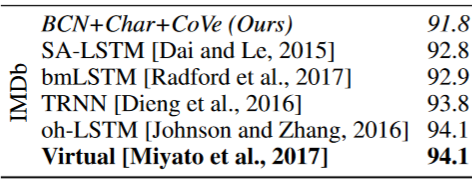

As you see, we just got a new state of the art result in sentiment analysis, decreasing the error from 5.9% to 5.5%! You should be able to get similarly world-class results on other NLP classification problems using the same basic steps.

There are many opportunities to further improve this, although we won't be able to get to them until part 2 of this course...